**Long Short Term Memory model**



In [5]:
!pip install --upgrade pandas 
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 11.3 MB 29.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.2 which is incompatible.


     |████████████████████████████████| 109 kB 32.1 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
#Importing libraries

#For fast numerical operations on matrices
import numpy as np

#For dataframes
import pandas as pd

#Linear regression library
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

#Plotting tool
import matplotlib.pyplot as plt


#date time
from datetime import datetime 

# For reading stock data from yahoo
from pandas_datareader import data


In [2]:
import math

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
from tensorflow.python.ops.math_ops import reduce_prod

plt.style.use('fivethirtyeight')

In [3]:
#Get the stock quote
amazon_df = data.DataReader('AMZN',data_source='yahoo',start='2012-08-15', end='2021-08-15')

In [4]:
#Show the data
amazon_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-08-15,238.139999,232.250000,232.259995,237.419998,3264700,237.419998
2012-08-16,242.820007,236.199997,237.720001,241.550003,4312100,241.550003
2012-08-17,243.350006,240.470001,240.600006,241.169998,3085800,241.169998
2012-08-20,241.649994,238.199997,241.369995,240.350006,1889900,240.350006
2012-08-21,243.850006,238.550003,240.880005,239.449997,2571500,239.449997


In [4]:
amazon_df.shape

(2264, 6)

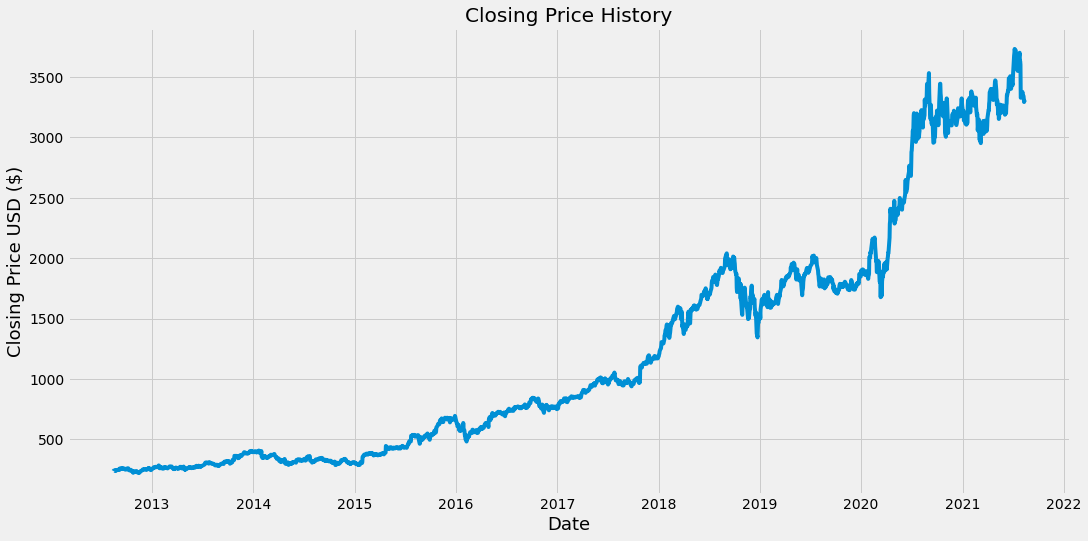

In [5]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Closing Price History')
plt.plot(amazon_df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Closing Price USD ($)',fontsize=18)
plt.show()

In [6]:
#Create a new data frame with only the close column
close_df=amazon_df.filter(['Close'])
close_df.head()

,Close
Date,
2012-08-15,237.419998
2012-08-16,241.550003
2012-08-17,241.169998
2012-08-20,240.350006
2012-08-21,239.449997


In [7]:
#Convert the dataframe to a numpy array
numarr = close_df.values
#Get the number of rows to train the model on
training_data_len = math.ceil(len(numarr) * 0.8)
training_data_len

1812

In [8]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(numarr)

scaled_data

array([[0.00479092],
       [0.00596728],
       [0.00585904],
       ...,
       [0.87487223],
       [0.87811647],
       [0.87540199]])

In [9]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

past_steps = 45

for i in range(past_steps,len(train_data)):
    x_train.append(train_data[i-past_steps:i,0])
    y_train.append(train_data[i,0])

In [10]:
#Convert the x_train and y_train to numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1767, 45, 1)

In [12]:
model = Sequential()
model.add(LSTM(50,return_sequences=False,input_shape= (past_steps,1)))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 11,701
Trainable params: 11,701
Non-trainable params: 0
_________________________________________________________________


In [13]:
#Compile the model
model.compile(optimizer='adam',loss='mean_squared_error')

In [14]:
#Train the model
model.fit(x_train,y_train,batch_size=1,epochs=1)

1767/1767 [==============================] - 34s 9ms/step - loss: 0.0025


In [16]:
#Create the testog dataaset
#Crate a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len-past_steps:,:]
#Create the data sets x_test and y_Test
x_test = []
y_test = numarr[training_data_len:,:]
for i in range(past_steps,len(test_data)):
    x_test.append(test_data[i-past_steps:i,0])

In [17]:
#Convert data into a numpy array
x_test = np.array(x_test)

#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [18]:
#Get the models predicted price values
predictions = model.predict(x_test)
#predictions
predictions = scaler.inverse_transform(predictions)
#predictions

In [19]:
#Get the rms error
rmse=np.sqrt(np.mean(predictions- y_test)**2)
rmse

120.43585448138482

In [20]:
# Using MAPE error metrics to check for the error rate and accuracy level
#from sklearn.metrics import mean_absolute_error
y_test_1d = y_test.flatten()
predictions_1d = predictions.flatten()


val = 0

for i in range(len(y_test_1d)):
    val += abs((y_test_1d[i]-predictions[i])/y_test_1d[i])


print((val/len(y_test_1d)) * 100)

[4.3097453]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show>

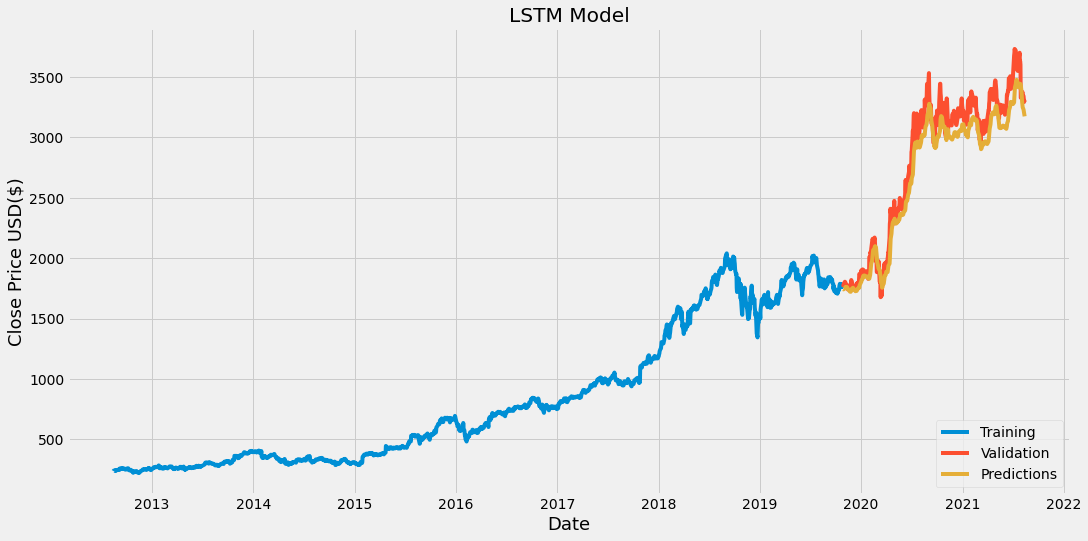

In [22]:
#Plot the data
train = close_df[:training_data_len]
valid = close_df[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validation','Predictions'],loc='lower right')
plt.show

In [23]:
valid

,Close,Predictions
Date,,
2019-10-29,1762.709961,1742.516724
2019-10-30,1779.989990,1741.190186
2019-10-31,1776.660034,1743.622681
2019-11-01,1791.439941,1744.898193
2019-11-04,1804.660034,1749.005371
...,...,...
2021-08-09,3341.870117,3229.920898
2021-08-10,3320.679932,3215.746826
2021-08-11,3292.110107,3200.975098
